In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Locate parent directory
data_dir = "./"

# Read csv file and display top 5 rows
df_train = pd.read_csv(data_dir+'train.csv')
df_test = pd.read_csv(data_dir+'/test.csv')

In [3]:
X_train = df_train.drop(['id','target'], axis=1)
# Take separate for class value
Y = df_train['target'].values
# Take test feature value
X_test = df_test.drop(['id'], axis=1)

In [4]:
from sklearn.metrics import roc_auc_score, make_scorer
def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5
    
scoring_roc_auc = make_scorer(scoring_roc_auc)

# Outlier Detection

In [5]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(n_jobs=-1, random_state=1)
isf.fit(X_train, Y)
isf.predict(X_train)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Seems like there isn't any outlier in the dataset

## Let's remove features with low varience


In [72]:
from sklearn.feature_selection import VarianceThreshold
# Var[X] = p(i-p) 
sel =  VarianceThreshold(threshold=1)
sel.fit(X_train)
print(sel.variances_.max(), sel.variances_.min())

1.2390050327839999 0.715986693584


We can see that, eveary feature has a significant varience<br>
So it's better to not remove any feature

# Scaling

In [14]:
from sklearn.preprocessing import StandardScaler
stand_vec = StandardScaler()
X_train = stand_vec.fit_transform(X_train)
X_test = stand_vec.transform(X_test)

In [181]:
# data =  RobustScaler().fit_transform(pd.concat([X_train, X_test], axis = 0))
# X_train = data[:250]
# X_test = data[250:]

# Balancing the Dataset

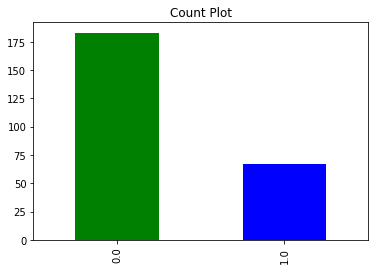

Points with class 0: 183
Points with class 1: 67


In [35]:
Y.value_counts().plot(kind='bar', title='Count Plot', color = ['g','b'])
plt.show()
print("Points with class 0: %d"%(len(Y) - np.count_nonzero(Y)))
print("Points with class 1: %d"%(np.count_nonzero(Y)))

## Class balancing using SMOTE

In [36]:
from imblearn.over_sampling import SMOTE
X_train_smote, Y_smote = SMOTE().fit_resample(X_train, Y)

In [37]:
X_train_smote.shape, Y_smote.shape

((366, 300), (366,))

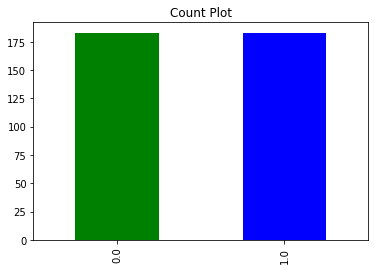

Points with class 0: 183
Points with class 1: 183


In [38]:
Y_smote.value_counts().plot(kind='bar', title='Count Plot', color = ['g','b'])
plt.show()
print("Points with class 0: %d"%(len(Y) - np.count_nonzero(Y)))
print("Points with class 1: %d"%(np.count_nonzero(Y_smote)))

## Applying ML Models

In [69]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
def print_confusion_matrix(y_test_pred, ytest ):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    for i in range(len(y_test_pred)):
        if y_test_pred[i]<0.5:
            y_test_pred[i] = 0
        else :
            y_test_pred[i] = 1
    class_label = ["negative", "positive"]
    cm = confusion_matrix(Y_test, y_test_pred)
    cm = cm/ cm.astype(np.float).sum(axis=0)
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = ".2f")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()


In [5]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, RepeatedStratifiedKFold
def hyperparameter_tune(models, params):
    '''
    Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by CalibratedClassifier
    
    Parameters:
    models: Instance of the model
    params: list of parameters with value for tuning (dict)
    
    Return:
    grid_clf: return gridsearch model    
    '''
    #https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn
    gscv = GridSearchCV(models, params, cv=RepeatedStratifiedKFold(n_splits=10, random_state=3), return_train_score=True, scoring='roc_auc', verbose = 2, n_jobs = -1)
    gscv.fit(X_train, Y)
    return gscv

## a. KNN

In [205]:
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors':np.arange(1,45,2), 'algorithm': ['kd_tree', 'brute']}
knn = KNeighborsClassifier()
knn_gs = hyperparameter_tune(knn, params)

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    9.9s finished


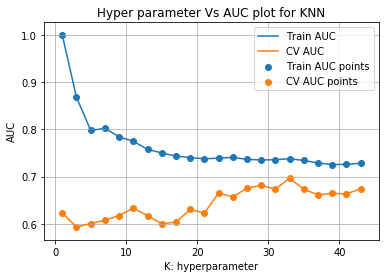

K                    Train Score          CV Score            
1                    1.00                 0.62                
3                    0.87                 0.59                
5                    0.80                 0.60                
7                    0.80                 0.61                
9                    0.78                 0.62                
11                   0.77                 0.63                
13                   0.76                 0.62                
15                   0.75                 0.60                
17                   0.74                 0.60                
19                   0.74                 0.63                
21                   0.74                 0.62                
23                   0.74                 0.66                
25                   0.74                 0.66                
27                   0.74                 0.68                
29                   0.74                 0.68         

In [206]:
results = pd.DataFrame.from_dict(knn_gs.cv_results_) 
K = results[results['param_algorithm'] == 'kd_tree']['param_n_neighbors']
train_auc = results[results['param_algorithm'] == 'kd_tree']['mean_train_score']
cv_auc = results[results['param_algorithm'] == 'kd_tree']['mean_test_score']
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for KNN")
plt.grid()
plt.show()
print("{:<20} {:<20} {:<20}".format('K', 'Train Score', 'CV Score'))
for i in range(len(K)):
    print("{:<20} {:<20.2f} {:<20.2f}".format(K.iloc[i], train_auc.iloc[i], cv_auc.iloc[i]))

In [ ]:
results = pd.DataFrame.from_dict(knn_gs.cv_results_) 
K = results[results['param_algorithm'] == 'brute']['param_n_neighbors']
train_auc = results[results['param_algorithm'] == 'brute']['mean_train_score']
cv_auc = results[results['param_algorithm'] == 'brute']['mean_test_score']
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for KNN")
plt.grid()
plt.show()
print("{:<20} {:<20} {:<20}".format('K', 'Train Score', 'CV Score'))
for i in range(len(K)):
    print("{:<20} {:<20.2f} {:<20.2f}".format(K.iloc[i], train_auc.iloc[i], cv_auc.iloc[i]))

In [211]:
knn_gs.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 33}

In [306]:
knn_model = KNeighborsClassifier(**knn_gs.best_params_)
knn_model.fit(X_train, Y)
clf = CalibratedClassifierCV(clf, cv=5)
clf.fit(X_train,Y)

CalibratedClassifierCV(base_estimator=CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                                                          booster=None,
                                                                                          colsample_bylevel=1,
                                                                                          colsample_bynode=1,
                                                                                          colsample_bytree=1,
                                                                                          gamma=0,
                                                                                          gpu_id=-1,
                                                                                          importance_type='gain',
                                                                                          interaction_constraints=None,
                         

In [229]:
knn_pred = clf.predict_proba(X_test)[:,1]

In [230]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = knn_pred
submission.to_csv('submission/knn_submission.csv', index=False)

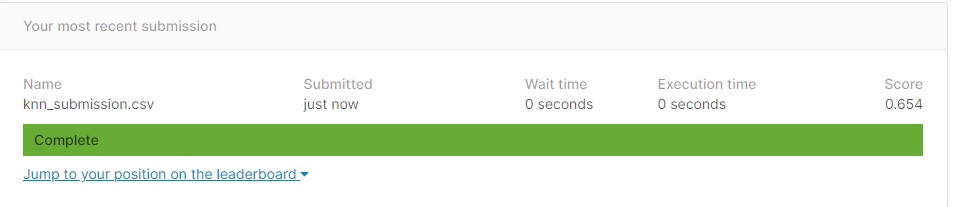

In [397]:
from IPython.display import Image
Image(filename='results/knn.jpg') 

## b. Logistic Regression

In [426]:
params = {'C':[1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'penalty':['l1', 'l2', 'elasticnet'], 'solver':['liblinear','sag']}
log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_clf = hyperparameter_tune(log_model, params)

Fitting 100 folds for each of 42 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2156 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:   46.3s finished


In [427]:
print(log_clf.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


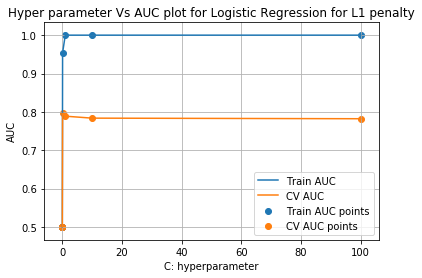

C                    penalty              Train Score         
0.0001               l1                   0.50                 0.50                
0.001                l1                   0.50                 0.50                
0.01                 l1                   0.50                 0.50                
0.1                  l1                   0.95                 0.80                
1                    l1                   1.00                 0.79                
10                   l1                   1.00                 0.78                
100                  l1                   1.00                 0.78                


In [428]:
results = pd.DataFrame.from_dict(log_clf.cv_results_) 
C = results[results['param_penalty'] == 'l1'][results['param_solver'] == 'liblinear']['param_C']
train_auc = results[results['param_penalty'] == 'l1'][results['param_solver'] == 'liblinear']['mean_train_score']
cv_auc = results[results['param_penalty'] == 'l1'][results['param_solver'] == 'liblinear']['mean_test_score']
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for Logistic Regression for L1 penalty")
plt.grid()
plt.show()
print("{:<20} {:<20} {:<20}".format('C', 'penalty', 'Train Score', 'CV Score'))
for i in range(len(C)):
    print("{:<20} {:<20} {:<20.2f} {:<20.2f}".format(C.iloc[i], 'l1', train_auc.iloc[i], cv_auc.iloc[i]))

In [25]:
log_model = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model.fit(X_train, Y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [341]:
clf = CalibratedClassifierCV(log_model, cv=3)
clf.fit(X_train,Y)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                         class_weight='balanced',
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l1',
                                                         random_state=42,
                                                         solver='liblinear',
                                                         tol=0.0001, verbose=0,
                                      

In [342]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('submission/lr_submission.csv', index=False)

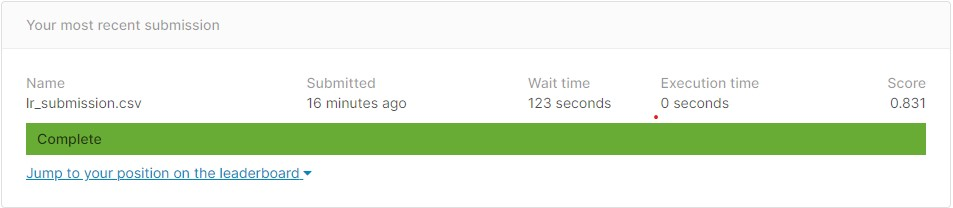

In [399]:
from IPython.display import Image
Image(filename='results/lr.jpg') 

## c.SVM rbf

In [484]:
from sklearn.svm import SVC
params = {'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
svc_model = SVC(class_weight='balanced', random_state=42, probability=True)
svc_clf = hyperparameter_tune(svc_model, params)

Fitting 100 folds for each of 49 candidates, totalling 4900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4900 out of 4900 | elapsed:  5.1min finished


In [249]:
svc_clf.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

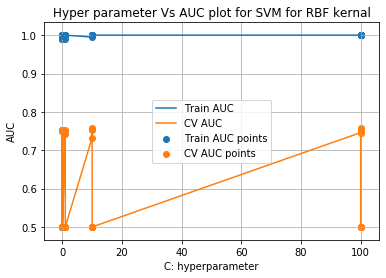

kernal               C                    gamma                Train Score          CV Score            
rbf                  0.0001               0.00                 0.99                 0.75                
rbf                  0.0001               0.00                 1.00                 0.75                
rbf                  0.0001               0.01                 1.00                 0.75                
rbf                  0.0001               0.10                 1.00                 0.50                
rbf                  0.0001               1.00                 1.00                 0.50                
rbf                  0.0001               10.00                1.00                 0.50                
rbf                  0.0001               100.00               1.00                 0.50                
rbf                  0.001                0.00                 0.99                 0.75                
rbf                  0.001                0.00         

In [256]:
results = pd.DataFrame.from_dict(svc_clf.cv_results_) 
C = results[results['param_kernel'] == 'rbf']['param_C']
gamma = results[results['param_kernel'] == 'rbf']['param_gamma']
train_auc = results[results['param_kernel'] == 'rbf']['mean_train_score']
cv_auc = results[results['param_kernel'] == 'rbf']['mean_test_score']
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for SVM for RBF kernal")
plt.grid()
plt.show()
print("{:<20} {:<20} {:<20} {:<20} {:<20}".format('kernal', 'C', 'gamma','Train Score', 'CV Score'))
for i in range(len(C)):
    print("{:<20} {:<20} {:<20.2f} {:<20.2f} {:<20.2f}".format('rbf', C.iloc[i], gamma.iloc[i], train_auc.iloc[i], cv_auc.iloc[i]))

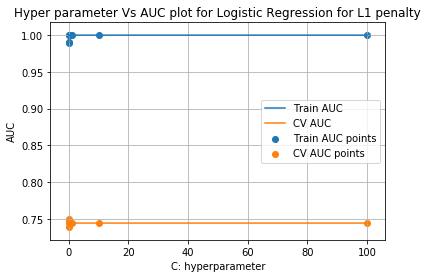

C                    kernal               Train Score         
1                    linear               0.99                 0.75                
3                    linear               0.99                 0.75                
5                    linear               1.00                 0.74                
7                    linear               1.00                 0.74                
9                    linear               1.00                 0.74                
11                   linear               1.00                 0.74                
13                   linear               1.00                 0.74                


In [253]:
results = pd.DataFrame.from_dict(svc_clf.cv_results_) 
C = results[results['param_kernel'] == 'linear']['param_C']
train_auc = results[results['param_kernel'] == 'linear']['mean_train_score']
cv_auc = results[results['param_kernel'] == 'linear']['mean_test_score']
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for SVM for linear kernal")
plt.grid()
plt.show()
print("{:<20} {:<20} {:<20} {:<20}".format('C', 'kernal', 'Train Score', 'CV Score'))
for i in range(len(C)):
    print("{:<20} {:<20} {:<20.2f} {:<20.2f}".format(C.iloc[i], 'linear', train_auc.iloc[i], cv_auc.iloc[i]))

In [21]:
svc_model = SVC(**svc_clf.best_params_, class_weight='balanced', random_state=42, probability=True)
svc_model.fit(X_train, Y)

clf = CalibratedClassifierCV(svc_model, cv=10)
clf.fit(X_train, Y)

CalibratedClassifierCV(base_estimator=SVC(C=10, break_ties=False,
                                          cache_size=200,
                                          class_weight='balanced', coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma=0.001, kernel='rbf',
                                          max_iter=-1, probability=True,
                                          random_state=42, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=10, method='sigmoid')

In [22]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('submission/svm_submission.csv', index=False)

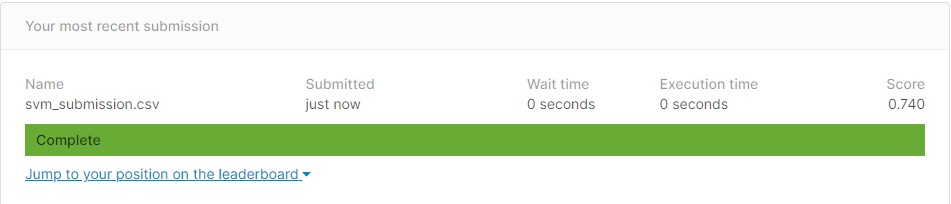

In [400]:
from IPython.display import Image
Image(filename='results/svc.jpg') 

## c.2 SVM Linear

In [15]:
from sklearn.svm import LinearSVC
params = { 'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'penalty':['l1', 'l2']}
svc_model = LinearSVC(class_weight='balanced', random_state=42)
svc_clf = hyperparameter_tune(svc_model, params)

Fitting 100 folds for each of 14 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    4.0s finished


In [16]:
svc_clf.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [17]:
svc_model_linear = LinearSVC(**svc_clf.best_params_, class_weight='balanced', random_state=42)
svc_model_linear.fit(X_train, Y)

clf = CalibratedClassifierCV(svc_model, cv=10)
clf.fit(X_train, Y)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight='balanced',
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=42, tol=0.0001,
                                                verbose=0),
                       cv=10, method='sigmoid')

In [18]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('submission/svm_linaer_submission.csv', index=False)

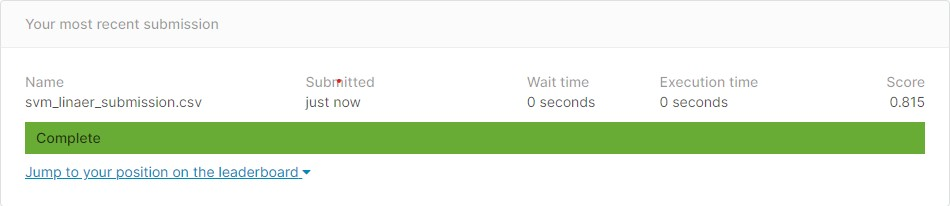

In [401]:
from IPython.display import Image
Image(filename='results/svmlinear.jpg') 

## d. RandomForest

In [273]:
from sklearn.ensemble import RandomForestClassifier

In [275]:
params = {'n_estimators':[10,20,40,60,100,200,300,500, 1000, 2000],'max_depth':[2,3,7,13]}
rf_model = RandomForestClassifier(random_state=42)
rf_clf = hyperparameter_tune(rf_model, params)

Fitting 100 folds for each of 40 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 65.2min finished


In [276]:
rf_clf.best_params_

{'max_depth': 3, 'n_estimators': 2000}

In [30]:
rf_model = RandomForestClassifier(**rf_clf.best_params_, random_state=42)
rf_model.fit(X_train, Y)
clf = CalibratedClassifierCV(rf_model, cv=3)
clf.fit(X_train, Y)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=3,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                  

In [344]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('submission/rf_submission.csv', index=False)

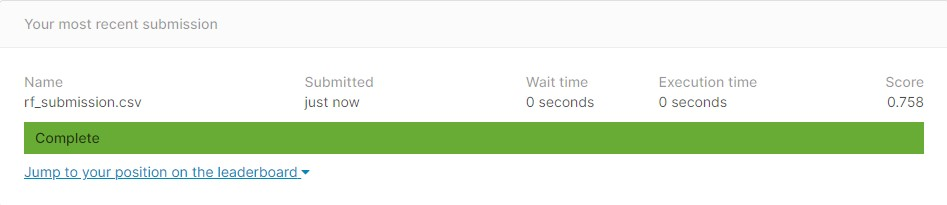

In [402]:
from IPython.display import Image
Image(filename='results/rf.jpg') 

## e. Gradient Boosting Classifier

In [302]:
from xgboost import XGBClassifier
params={
    'learning_rate':[0.01,0.05,0.1],
     'n_estimators':[100,500,1000],
     'max_depth':[2,3]
}
# Instance of XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=0.5)
import time
start = time.time()
xgb_clf = hyperparameter_tune(xgb_model, params)
print("time taken = {}".format(time.time() - start))

Fitting 100 folds for each of 18 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 45.0min finished


time taken = 2706.1362574100494


In [303]:
xgb_clf.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000}

In [24]:
xgb_model = XGBClassifier(learning_raet=0.1, max_depth=2,n_estimators=1000, random_state=42, scale_pos_weight=0.5)
# Fit the model
xgb_model.fit(X_train, Y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_raet=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [304]:
# Instance of randomforest with best parameters
xgb_model = XGBClassifier(**xgb_clf.best_params_, random_state=42, scale_pos_weight=0.5)
# Fit the model
xgb_model.fit(X_train, Y)

clf = CalibratedClassifierCV(xgb_model, cv=3)
clf.fit(X_train, Y)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=2,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constraints=Non

In [305]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('submission/gbdt_submission.csv', index=False)

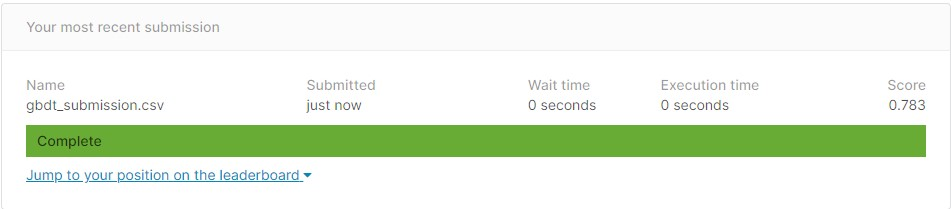

In [403]:
from IPython.display import Image
Image(filename='results/gbdt.jpg') 

## f. Stacking Classifier

In [385]:
from mlxtend.classifier import StackingClassifier
 
clf1 = CalibratedClassifierCV(log_model, cv=5)
clf2 = CalibratedClassifierCV(svc_model, cv=5)
clf3 = CalibratedClassifierCV(svc_model_linear, cv=5)
clf4 = CalibratedClassifierCV(rf_model,  cv=5)
clf5 = CalibratedClassifierCV(xgb_model, cv=5)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1,clf2,clf3,clf4, clf5], meta_classifier=lr, use_probas=True)
 
sclf.fit(X_train, Y)

StackingClassifier(average_probas=False,
                   classifiers=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                         class_weight='balanced',
                                                                                         dual=False,
                                                                                         fit_intercept=True,
                                                                                         intercept_scaling=1,
                                                                                         l1_ratio=None,
                                                                                         max_iter=100,
                                                                                         multi_class='auto',
                                                                                         n_jobs=None,
           

In [23]:
from mlxtend.classifier import StackingClassifier
 

In [386]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = sclf.predict_proba(X_test)[:,1]
submission.to_csv('submission/stackclf1_submission.csv', index=False)

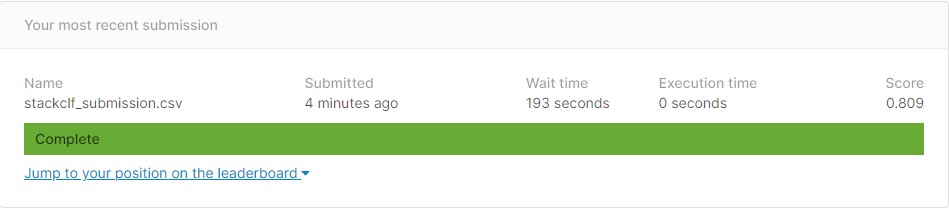

In [404]:
from IPython.display import Image
Image(filename='results/stackclf.jpg') 

## f.2 Stacking Classifier with important Classifiers

In [26]:
from mlxtend.classifier import StackingClassifier

clf1 = CalibratedClassifierCV(log_model, cv=5)
clf3 = CalibratedClassifierCV(svc_model_linear, cv=5)
clf5 = CalibratedClassifierCV(xgb_model, cv=5)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1,clf3, clf5], meta_classifier=lr, use_probas=True)
 
sclf.fit(X_train, Y)

StackingClassifier(average_probas=False,
                   classifiers=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                         class_weight='balanced',
                                                                                         dual=False,
                                                                                         fit_intercept=True,
                                                                                         intercept_scaling=1,
                                                                                         l1_ratio=None,
                                                                                         max_iter=100,
                                                                                         multi_class='auto',
                                                                                         n_jobs=None,
           

In [27]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = sclf.predict_proba(X_test)[:,1]
submission.to_csv('submission/stackclf2_submission.csv', index=False)

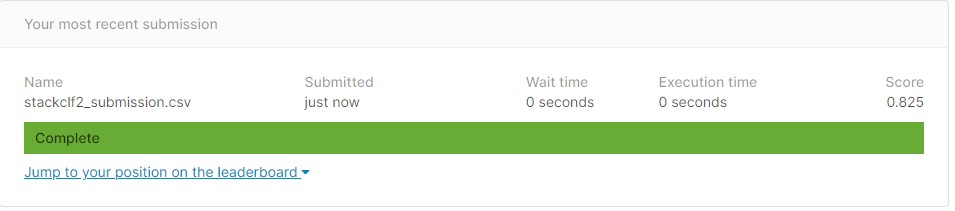

In [405]:
from IPython.display import Image
Image(filename='results/stackclf2.jpg') 

## g. Maximum Voting Classifier

In [312]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2,clf3,clf4])
eclf.fit(X_train,Y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                               

In [351]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = eclf.predict_proba(X_test)[:,1]
submission.to_csv('submission/voteclf_submission.csv', index=False)

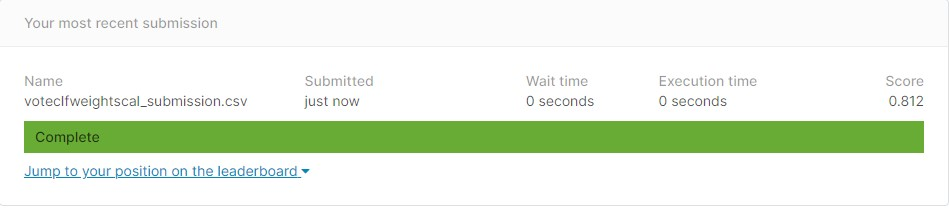

In [410]:
from IPython.display import Image
Image(filename='results/voteclfweights.jpg') 

In [389]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[clf1,clf2,clf3,clf4,clf5], weights=[0.3,0.15,0.25,0.1, 0.20])
eclf.fit(X_train,Y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                               

In [390]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = eclf.predict_proba(X_test)[:,1]
submission.to_csv('submission/voteclfweights1_submission.csv', index=False)

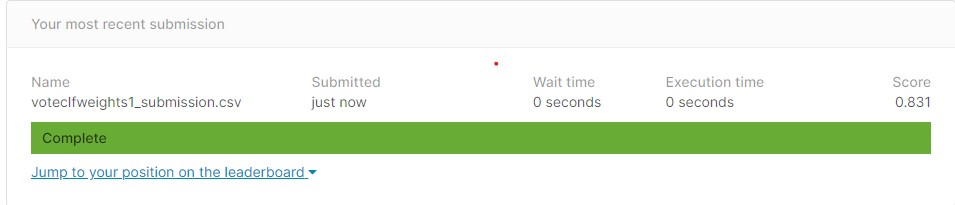

In [409]:
from IPython.display import Image
Image(filename='results/voteclfweights1.jpg') 

## Voting Classifier with important classifiers

In [33]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[clf1,clf3,clf5],weights=[0.36,0.32,0.32])
eclf.fit(X_train,Y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                               

In [34]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = eclf.predict_proba(X_test)[:,1]
submission.to_csv('submission/voteclfweights2_submission.csv', index=False)

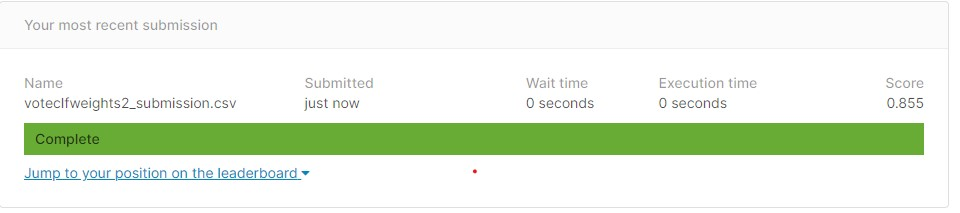

In [108]:
from IPython.display import Image
Image(filename='results/voteclfweights2.jpg') 

## Using SVD to reduce feature

In [354]:
from sklearn.decomposition import TruncatedSVD

In [359]:
from sklearn.decomposition import TruncatedSVD
n_components = [5,10,20,10, 25, 50,100,125,150,200,225, 250]
varience = []
for x in n_components:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train)
    varience.append(svd.explained_variance_ratio_.sum())
    print("Number of components = {0} and explained variance = {1}".format(x, svd.explained_variance_ratio_.sum()) )


Number of components = 5 and explained variance = 0.06611818573539543
Number of components = 10 and explained variance = 0.12724970689458795
Number of components = 20 and explained variance = 0.23698839929085205
Number of components = 10 and explained variance = 0.1267931695925611
Number of components = 25 and explained variance = 0.28679557384819626
Number of components = 50 and explained variance = 0.4983722672203029
Number of components = 100 and explained variance = 0.7786505937966427
Number of components = 125 and explained variance = 0.8646093041679355
Number of components = 150 and explained variance = 0.924541689885163
Number of components = 200 and explained variance = 0.9853656745844921
Number of components = 225 and explained variance = 0.9966735470970272
Number of components = 250 and explained variance = 1.0000000000000004


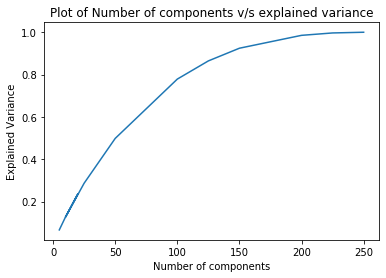

In [360]:
plt.plot(n_components, varience)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [393]:
svd = TruncatedSVD(n_components= 200)
svd.fit(X_train)
X_trainsvd = svd.transform(X_train)
X_testsvd = svd.transform(X_test)
print(X_trainsvd.shape, X_testsvd.shape)

(250, 200) (19750, 200)


In [394]:
from mlxtend.classifier import EnsembleVoteClassifier
eclf = EnsembleVoteClassifier(clfs=[clf1,clf3,clf5], weights=[0.36,0.32,0.32])
eclf.fit(X_trainsvd,Y)

EnsembleVoteClassifier(clfs=[CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                                                      class_weight='balanced',
                                                                                      dual=False,
                                                                                      fit_intercept=True,
                                                                                      intercept_scaling=1,
                                                                                      l1_ratio=None,
                                                                                      max_iter=100,
                                                                                      multi_class='auto',
                                                                                      n_jobs=None,
                                                                               

In [395]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = eclf.predict_proba(X_testsvd)[:,1]
submission.to_csv('submission/voteclfweightssvd_submission.csv', index=False)

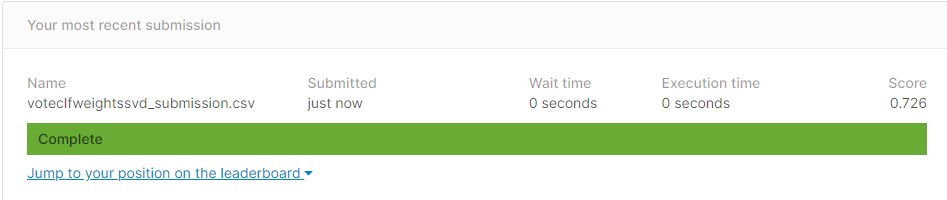

In [487]:
from IPython.display import Image
Image(filename='results/voteclfweightsvd.jpg') 

## Lasso Classifier

In [36]:
train_X += np.random.normal(0, 0.01, train_X.shape)

In [463]:
from sklearn.linear_model import Lasso, RidgeClassifier
model = Lasso(alpha=0.031, tol=0.01, random_state=42, selection='random')

param_grid = {
            'alpha' : [0.021, 0.029, 0.031, 0.1, 0.3, 0.5],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
}
model = hyperparameter_tune(model, param_grid)

Fitting 100 folds for each of 48 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1215 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 3245 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   24.1s finished


In [464]:
model.best_params_

{'alpha': 0.031, 'tol': 0.001}

In [37]:
model_lasso = Lasso(alpha = 0.031, tol = 0.001)
model_lasso.fit(X_train, Y)

Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.001, warm_start=False)

In [466]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model_lasso.predict(X_test)
submission.to_csv('submission/lasso.csv', index=False)

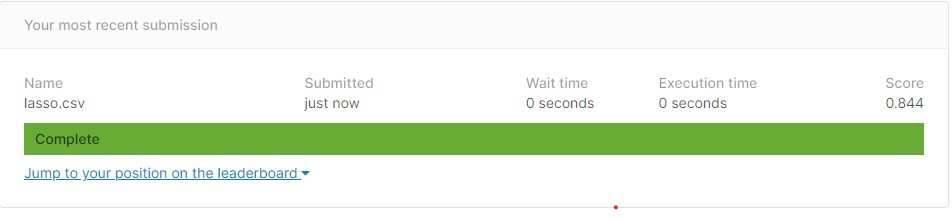

In [443]:
from IPython.display import Image
Image(filename='results/lasso.jpg') 

## Ridge Regressor

In [54]:
from sklearn.linear_model import Lasso, RidgeClassifier
model = RidgeClassifier(alpha=0.031, tol=0.01, random_state=42)

param_grid = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
}
model = hyperparameter_tune(model, param_grid)

Fitting 100 folds for each of 88 candidates, totalling 8800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2636 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 6290 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 8800 out of 8800 | elapsed:   34.2s finished


In [55]:
model.best_params_

{'alpha': 0.024, 'tol': 0.0013}

In [56]:
model_ridge = RidgeClassifier(**model.best_params_)
model_ridge.fit(X_train, Y)

RidgeClassifier(alpha=0.024, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.0013)

In [57]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model_ridge.predict(X_test)
submission.to_csv('submission/ridge.csv', index=False)

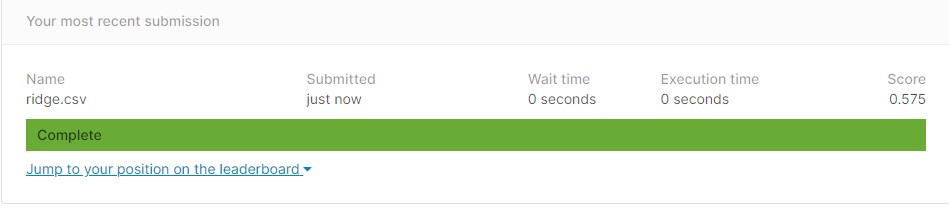

In [65]:
from IPython.display import Image
Image(filename='results/ridge.jpg') 

## ElasticNet

In [51]:
from sklearn.linear_model import ElasticNet 
model = ElasticNet(alpha=0.031, tol=0.01, random_state=42)

param_grid = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
}
model = hyperparameter_tune(model, param_grid)

Fitting 100 folds for each of 88 candidates, totalling 8800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2928 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 6988 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 8800 out of 8800 | elapsed:   22.8s finished


In [52]:
model_elastic = ElasticNet(**model.best_params_)
model_elastic.fit(X_train, Y)

ElasticNet(alpha=0.029, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.001, warm_start=False)

In [53]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model_elastic.predict(X_test)
submission.to_csv('submission/elasticnet.csv', index=False)

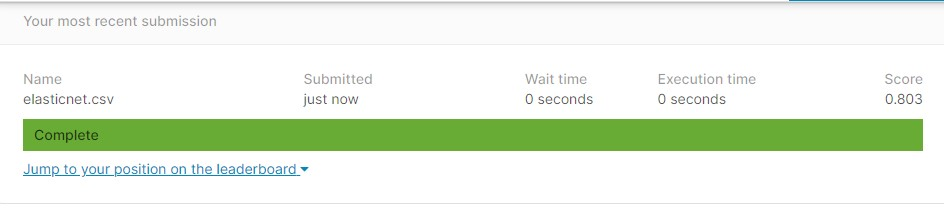

In [66]:
from IPython.display import Image
Image(filename='results/elasticnet.jpg') 

## XGBoost Regressior

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

In [467]:
gbr = GradientBoostingRegressor()

param_grid = {
            'learning_rate' : [ 0.02, 0.1, 0.5],
            'n_estimators'   : [10, 100,  200, 500]
}
gbr_gs = hyperparameter_tune(gbr, param_grid)

Fitting 100 folds for each of 12 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 34.6min finished


In [468]:
gbr_gs.best_params_

{'learning_rate': 0.02, 'n_estimators': 500}

In [46]:
model_xgbreg = GradientBoostingRegressor(learning_rate = 0.02, n_estimators = 500)
model_xgbreg.fit(X_train, Y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.02, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [471]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model_xgbreg.predict(X_test)
submission.to_csv('submission/xgb.csv', index=False)

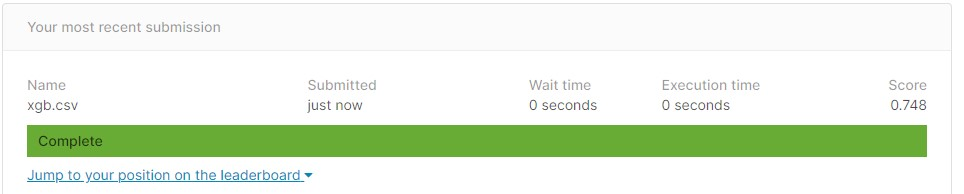

In [67]:
from IPython.display import Image
Image(filename='results/xgb.jpg') 

## Stacking Regressor

In [59]:
from sklearn.linear_model import LinearRegression

In [88]:
from mlxtend.regressor import StackingRegressor

lr = RidgeClassifier()

sclf = StackingRegressor(regressors=[model_lasso, model_elastic, model_xgbreg], meta_regressor=lr)
 
sclf.fit(X_train, Y)

StackingRegressor(meta_regressor=RidgeClassifier(alpha=1.0, class_weight=None,
                                                 copy_X=True,
                                                 fit_intercept=True,
                                                 max_iter=None, normalize=False,
                                                 random_state=None,
                                                 solver='auto', tol=0.001),
                  refit=True,
                  regressors=[Lasso(alpha=0.031, copy_X=True,
                                    fit_intercept=True, max_iter=1000,
                                    normalize=False, positive=False,
                                    precompute=False, random_state=None,
                                    selection='cyclic...
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                           

In [89]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = sclf.predict(X_test)
submission.to_csv('submission/reg_.csv', index=False)

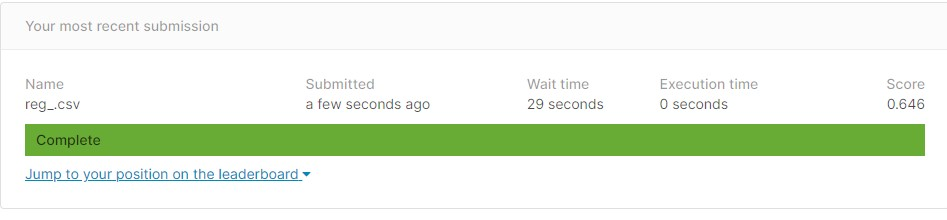

In [95]:
from IPython.display import Image
Image(filename='results/reg_.jpg') 

# Results

In [111]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from prettytable import PrettyTable
x = PrettyTable()
x.title = "Classifiers"
x.field_names = ['Model',    'Information',        'Hyperparameter',                                 'Test Score']
x.add_row(['KNN',                '-',r"{'algorithm': 'kd_tree', 'n_neighbors': 33}",                      65.4])
x.add_row(['Logistic Regression','-',r"{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}",               83.1])
x.add_row(['SVM RBF',            '-',r"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",                       74.0])
x.add_row(['LinearSVM',          '-',r"{'C': 0.001, 'penalty': 'l2'}",                                    81.5])
x.add_row(['RandomForest',       '-',r"{'max_depth': 3, 'n_estimators': 2000}",                           75.8])
x.add_row(['XGBoost',            '-',r"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000}",     78.3])

x.add_row(['Stacking Classifier','All',                      '-',                                         80.9]) 
x.add_row(['Stacking Classifier','LR+LinearSVM+XGB',         '-',                                         82.5]) 

x.add_row(['Voting Classifier','All',                        "-",                                         81.2])
x.add_row(['Voting Classifier','ALL + weighted',             "-",                                         83.1])
x.add_row(['Voting Classifier','LR+LinearSVM+XGB + weighted',"-",                                         85.5]) 
print(x)

+---------------------+-----------------------------+--------------------------------------------------------------+------------+
|        Model        |         Information         |                        Hyperparameter                        | Test Score |
+---------------------+-----------------------------+--------------------------------------------------------------+------------+
|         KNN         |              -              |         {'algorithm': 'kd_tree', 'n_neighbors': 33}          |    65.4    |
| Logistic Regression |              -              |      {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}      |    83.1    |
|       SVM RBF       |              -              |          {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}          |    74.0    |
|      LinearSVM      |              -              |                {'C': 0.001, 'penalty': 'l2'}                 |    81.5    |
|     RandomForest    |              -              |            {'max_depth': 3, 'n_estim

In [110]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Model', 'Information', 'Hyperparameter','Test Score']
x.add_row(['Lasso',                      '-',        r"{'alpha': 0.031, 'tol': 0.001}",                      84.4])
x.add_row(['Ridge',                      '-',        r"{'alpha': 0.024, 'tol': 0.0013}",                     57.5])
x.add_row(['ElasticNet',                 '-',        r"{'alpha': 0.029, 'tol': 0.001}",                      80.3])
x.add_row(['XGBRegressor',               '-',        r"{'learning_rate': 0.02, 'n_estimators': 500}",        74.8]) 

x.add_row(['Stacking Regressor',         'All',                      '-',                                    64.6])
print(x)

+--------------------+-------------+----------------------------------------------+------------+
|       Model        | Information |                Hyperparameter                | Test Score |
+--------------------+-------------+----------------------------------------------+------------+
|       Lasso        |      -      |        {'alpha': 0.031, 'tol': 0.001}        |    84.4    |
|       Ridge        |      -      |       {'alpha': 0.024, 'tol': 0.0013}        |    57.5    |
|     ElasticNet     |      -      |        {'alpha': 0.029, 'tol': 0.001}        |    80.3    |
|    XGBRegressor    |      -      | {'learning_rate': 0.02, 'n_estimators': 500} |    74.8    |
| Stacking Regressor |     All     |                      -                       |    64.6    |
+--------------------+-------------+----------------------------------------------+------------+


# Conclusion 

1. Best Model - Mlextend maximumVotingClassifier
        a. Test Score - 85.5
        b. Voting is done by Logistic Regression, LinearSVM, XGBoost with weights : [0.36,0.32,0.32]
2. 2nd Best Model - Lasso Regressor
        a. test Score - 84.4
        b. with parameters = alpha: 0.031, tol: 0.001
3. After Experimenting we got, SMOTE Doesn't work in this problem much.
